# Projeto Final MC886
## Imputação de dados de Pressão Arterial reais utilizando Redes Adversárias Generativas

#### Giovanne Lucas (173317), Luciano Fabris (173093) e Marta Fernandez (948383)

## This is a Generative Adversarial Network (GAN) implemented to suit MNIST dataset of digits.

#### Built with the help of [Medium GAN using Keras](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)

In [1]:
# import essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import keras and tqdm
import keras
from keras.layers import Dense, Dropout, Input, Reshape, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

# import data management utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def normalize_data(x_train, x_val, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    return (x_train, x_val, x_test)

# not used in this case
def encode_data(y_train, y_val, y_test, categories):
    # one-hot encode the training and testing labels
    y_train = np_utils.to_categorical(y_train, categories)
    y_val = np_utils.to_categorical(y_val, categories)
    y_test = np_utils.to_categorical(y_test, categories)
    return y_train, y_val, y_test

def load_data1():
    # load and split data from mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    x_train = x_train.reshape((x_train.shape[0], 784))
    x_val = x_val.reshape((x_val.shape[0], 784))
    x_test = x_test.reshape((x_test.shape[0], 784))
    # normalize and encode data
    x_train, x_val, x_test = normalize_data(x_train, x_val, x_test)
    return (x_train, y_train, x_val, y_val, x_test, y_test)

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

#(x_train, y_train, x_val, y_val, x_test, y_test) = load_data()
#print("Data shape after preprocessing:")
#print("x_train and y_train: ", x_train.shape, y_train.shape)
#print("x_val and y_val: ", x_val.shape, y_val.shape)
#print("x_test and y_test: ", x_test.shape, y_test.shape)

In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

generator = create_generator()
generator.summary()
    
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(discriminator, generator)
gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [4]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  5.43it/s]


Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.92it/s]


Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.97it/s]


Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 11


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 12


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 13


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.37it/s]


Epoch 14


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.18it/s]


Epoch 15


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.31it/s]


Epoch 16


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 17


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 18


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 19


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.29it/s]


Epoch 20


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.04it/s]


Epoch 21


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 22


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 23


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 24


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  5.87it/s]


Epoch 25


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.21it/s]


Epoch 26


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.28it/s]


Epoch 27


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 28


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 29


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 30


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 31


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 32


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 33


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 34


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 35


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.16it/s]


Epoch 36


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 37


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 38


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.02it/s]


Epoch 39


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Epoch 40


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.31it/s]


Epoch 41


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.29it/s]


Epoch 42


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 43


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.21it/s]


Epoch 44


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.25it/s]


Epoch 45


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.34it/s]


Epoch 46


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 47


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 48


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 49


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 50


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 51


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.02it/s]


Epoch 52


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 53


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.24it/s]


Epoch 54


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 55


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 56


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.34it/s]


Epoch 57


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 58


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 59


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 60


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.32it/s]


Epoch 61


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 62


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 63


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.32it/s]


Epoch 64


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.30it/s]


Epoch 65


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.30it/s]


Epoch 66


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 67


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 68


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 69


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 70


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 71


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.08it/s]


Epoch 72


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  5.94it/s]


Epoch 73


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 74


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 75


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 76


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.29it/s]


Epoch 77


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Epoch 78


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 79


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 80


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 81


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.23it/s]


Epoch 82


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 83


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 84


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 85


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.25it/s]


Epoch 86


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 87


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.09it/s]


Epoch 88


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 89


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.21it/s]


Epoch 90


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 91


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.26it/s]


Epoch 92


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 93


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 94


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 95


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.20it/s]


Epoch 96


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 97


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  5.90it/s]


Epoch 98


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 99


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 100


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.29it/s]


Epoch 101


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.36it/s]


Epoch 102


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 103


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 104


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 105


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 106


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.07it/s]


Epoch 107


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 108


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.09it/s]


Epoch 109


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Epoch 110


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.26it/s]


Epoch 111


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.34it/s]


Epoch 112


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.20it/s]


Epoch 113


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 114


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.07it/s]


Epoch 115


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.19it/s]


Epoch 116


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 117


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 118


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 119


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.37it/s]


Epoch 120


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.00it/s]


Epoch 121


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.13it/s]


Epoch 122


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 123


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 124


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 125


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.23it/s]


Epoch 126


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 127


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 128


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.37it/s]


Epoch 129


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 130


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.07it/s]


Epoch 131


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.10it/s]


Epoch 132


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.32it/s]


Epoch 133


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.21it/s]


Epoch 134


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 135


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.18it/s]


Epoch 136


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  4.88it/s]


Epoch 137


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  6.01it/s]


Epoch 138


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 139


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.25it/s]


Epoch 140


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.13it/s]


Epoch 141


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 142


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 143


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.28it/s]


Epoch 144


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.06it/s]


Epoch 145


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.15it/s]


Epoch 146


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 147


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.25it/s]


Epoch 148


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.32it/s]


Epoch 149


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 150


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.22it/s]


Epoch 151


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.06it/s]


Epoch 152


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 153


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.35it/s]


Epoch 154


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.25it/s]


Epoch 155


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 156


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.19it/s]


Epoch 157


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.10it/s]


Epoch 158


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 159


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 160


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 161


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.07it/s]


Epoch 162


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.05it/s]


Epoch 163


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.22it/s]


Epoch 164


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.21it/s]


Epoch 165


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 166


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 167


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.23it/s]


Epoch 168


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.04it/s]


Epoch 169


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.11it/s]


Epoch 170


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.16it/s]


Epoch 171


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:19<00:00,  6.09it/s]


Epoch 172


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.10it/s]


Epoch 173


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.05it/s]


Epoch 174


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.05it/s]


Epoch 175


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [55:26<00:00,  4.03it/s]


Epoch 176


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  5.96it/s]


Epoch 177


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 178


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.15it/s]


Epoch 179


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.31it/s]


Epoch 180


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 181


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  6.06it/s]


Epoch 182


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 183


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.01it/s]


Epoch 184


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 185


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 186


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Epoch 187


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.23it/s]


Epoch 188


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.27it/s]


Epoch 189


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 190


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.23it/s]


Epoch 191


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.98it/s]


Epoch 192


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.23it/s]


Epoch 193


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.18it/s]


Epoch 194


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.28it/s]


Epoch 195


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.16it/s]


Epoch 196


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  5.88it/s]


Epoch 197


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.99it/s]


Epoch 198


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.04it/s]


Epoch 199


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.09it/s]


Epoch 200


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.17it/s]
C:\Users\gio_i\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Epoch 201


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.19it/s]


Epoch 202


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.23it/s]


Epoch 203


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 204


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.05it/s]


Epoch 205


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.10it/s]


Epoch 206


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  5.97it/s]


Epoch 207


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 208


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.09it/s]


Epoch 209


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.04it/s]


Epoch 210


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.08it/s]


Epoch 211


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.06it/s]


Epoch 212


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.12it/s]


Epoch 213


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 214


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.13it/s]


Epoch 215


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.21it/s]


Epoch 216


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.05it/s]


Epoch 217


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.17it/s]


Epoch 218


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.93it/s]


Epoch 219


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 220


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.15it/s]


Epoch 221


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.09it/s]


Epoch 222


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 223


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.99it/s]


Epoch 224


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.16it/s]


Epoch 225


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  5.52it/s]


Epoch 226


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  6.05it/s]


Epoch 227


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.97it/s]


Epoch 228


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  4.92it/s]


Epoch 229


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:22<00:00,  5.97it/s]


Epoch 230


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:23<00:00,  5.68it/s]


Epoch 231


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.86it/s]


Epoch 232


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.99it/s]


Epoch 233


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 234


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.78it/s]


Epoch 235


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.88it/s]


Epoch 236


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.97it/s]


Epoch 237


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.95it/s]


Epoch 238


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 239


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 240


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 241


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.96it/s]


Epoch 242


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 243


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.90it/s]


Epoch 244


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.93it/s]


Epoch 245


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.92it/s]


Epoch 246


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.94it/s]


Epoch 247


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.74it/s]


Epoch 248


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.96it/s]


Epoch 249


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.19it/s]


Epoch 250


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 251


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.07it/s]


Epoch 252


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.95it/s]


Epoch 253


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.16it/s]


Epoch 254


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.02it/s]


Epoch 255


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 256


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.99it/s]


Epoch 257


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 258


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.04it/s]


Epoch 259


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 260


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 261


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.85it/s]


Epoch 262


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.97it/s]


Epoch 263


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.11it/s]


Epoch 264


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 265


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.99it/s]


Epoch 266


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.13it/s]


Epoch 267


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.02it/s]


Epoch 268


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.55it/s]


Epoch 269


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.93it/s]


Epoch 270


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.15it/s]


Epoch 271


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 272


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 273


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.25it/s]


Epoch 274


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 275


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 276


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.19it/s]


Epoch 277


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 278


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.03it/s]


Epoch 279


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.05it/s]


Epoch 280


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.02it/s]


Epoch 281


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 282


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.15it/s]


Epoch 283


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.23it/s]


Epoch 284


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.12it/s]


Epoch 285


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 286


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.08it/s]


Epoch 287


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.09it/s]


Epoch 288


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.97it/s]


Epoch 289


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.06it/s]


Epoch 290


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.89it/s]


Epoch 291


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.20it/s]


Epoch 292


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.00it/s]


Epoch 293


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.12it/s]


Epoch 294


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.13it/s]


Epoch 295


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.91it/s]


Epoch 296


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.13it/s]


Epoch 297


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.95it/s]


Epoch 298


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.12it/s]


Epoch 299


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  6.22it/s]


Epoch 300


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:21<00:00,  5.98it/s]


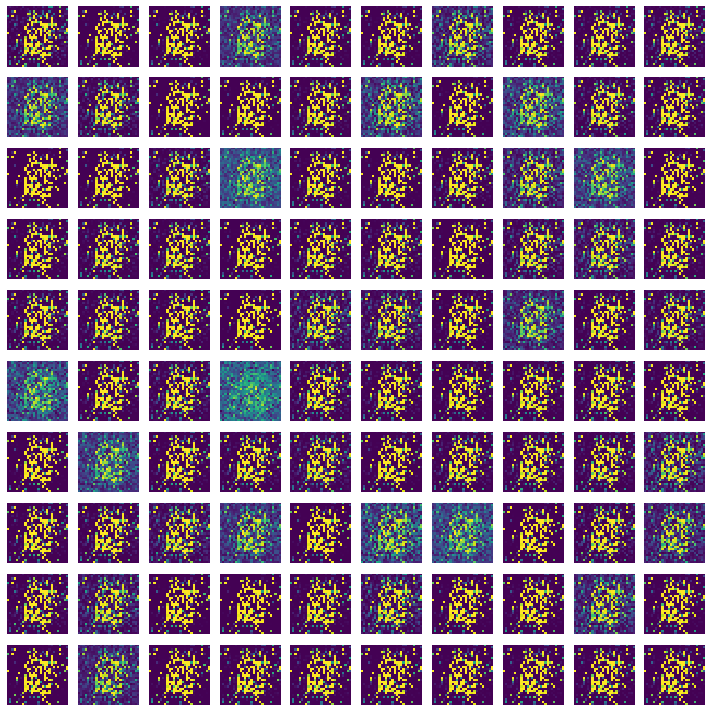

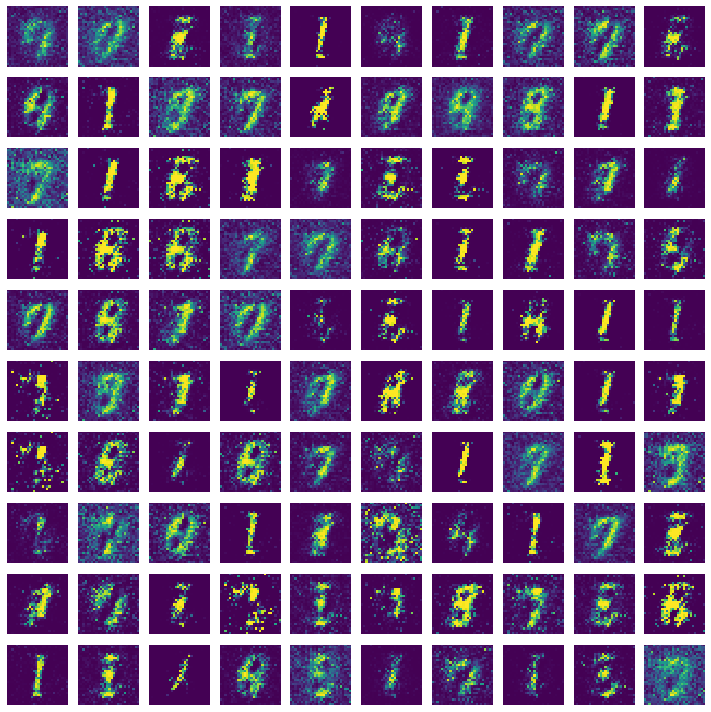

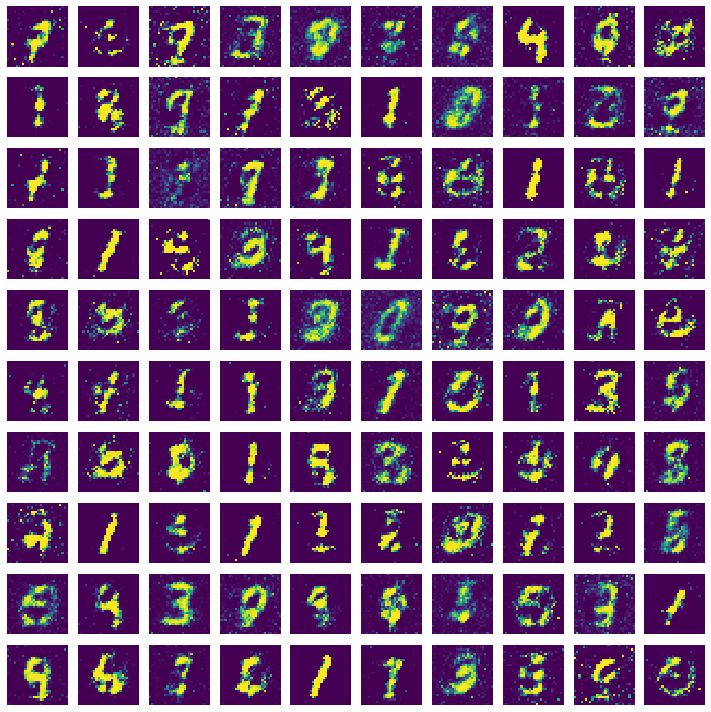

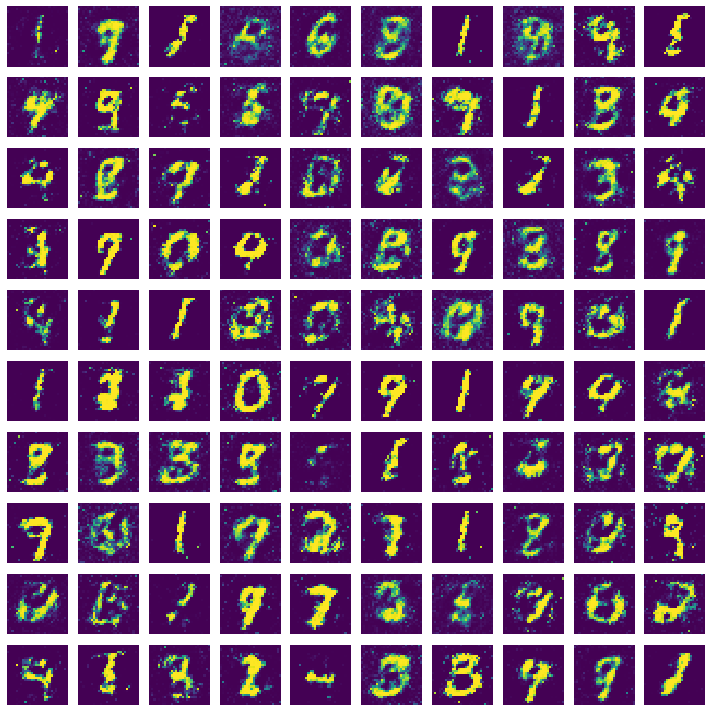

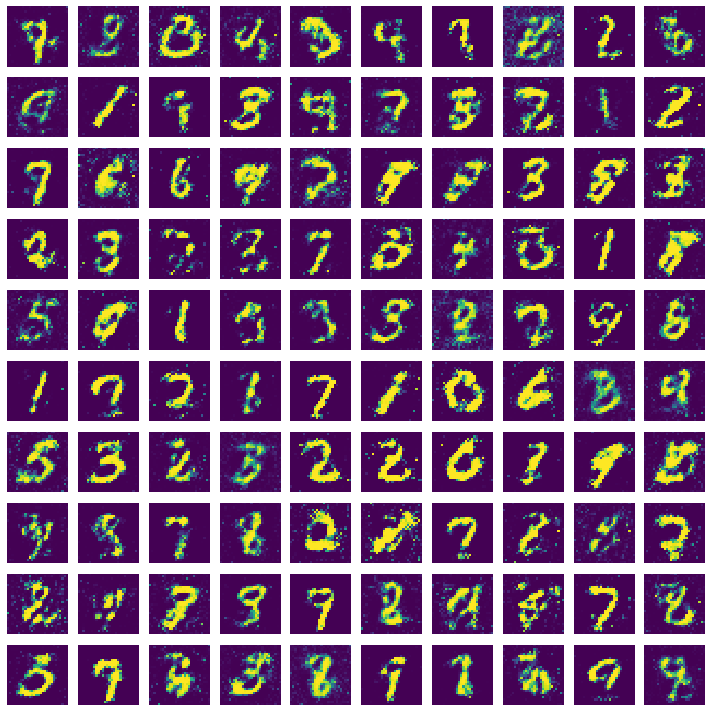

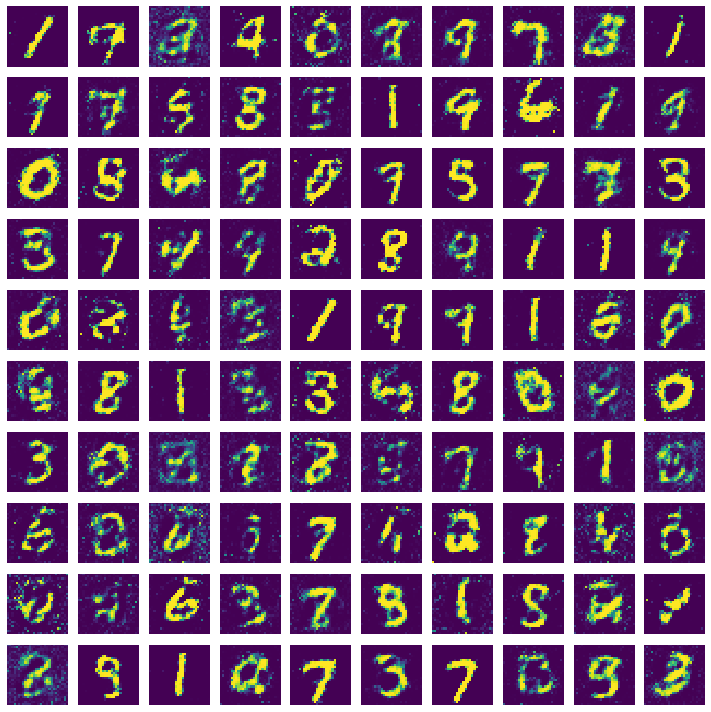

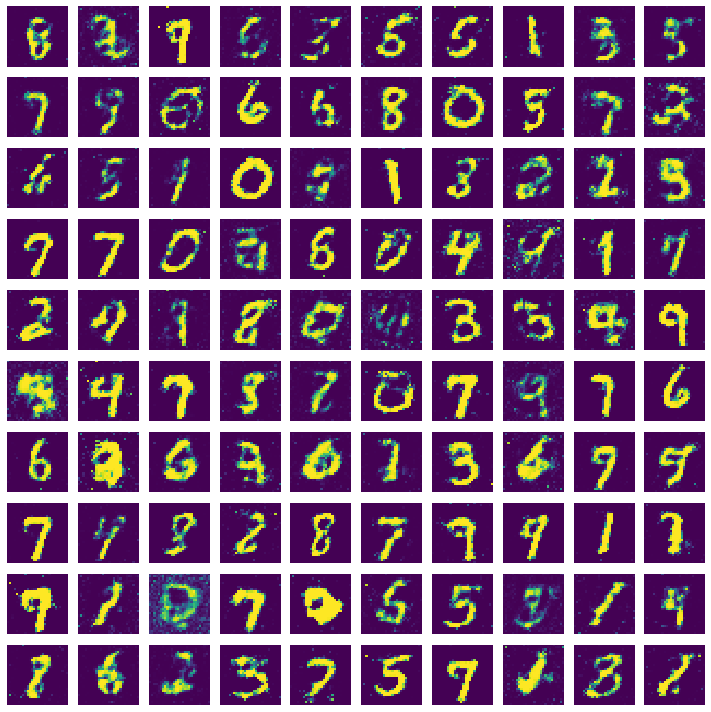

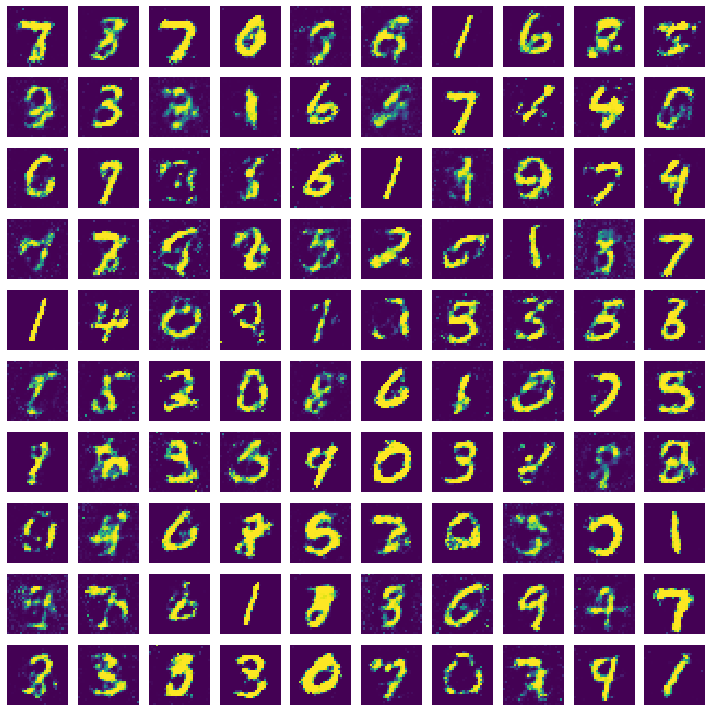

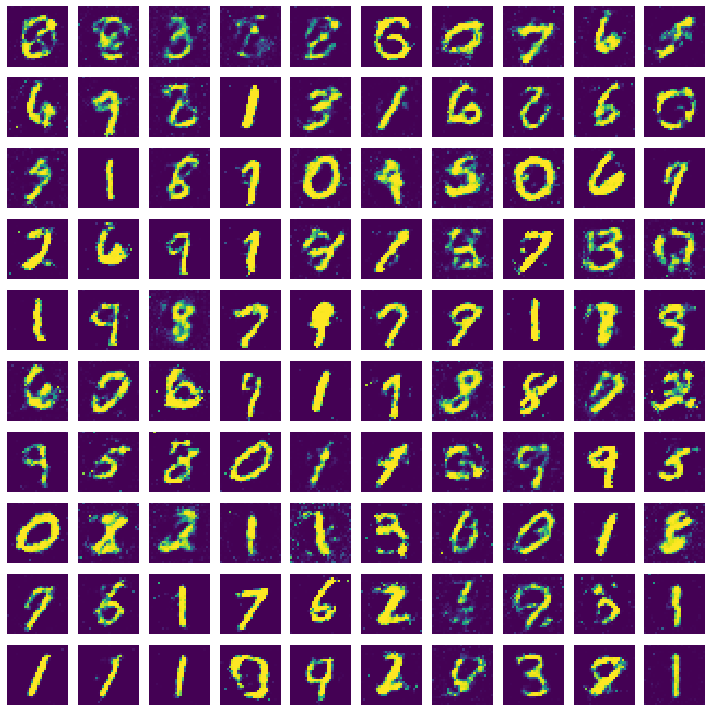

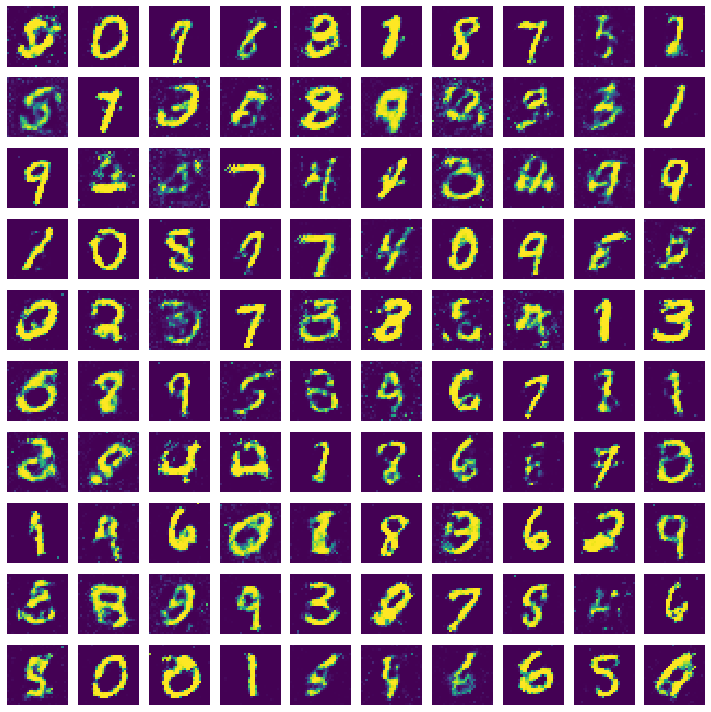

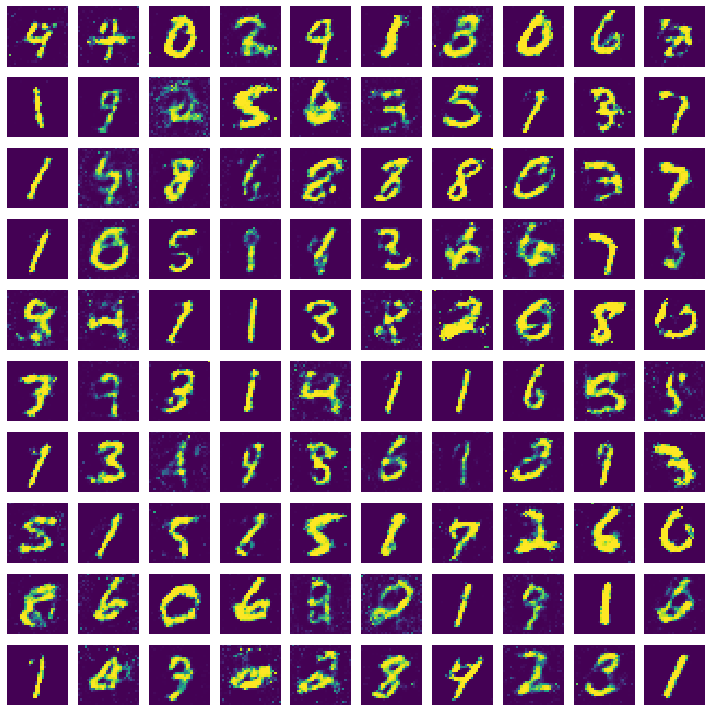

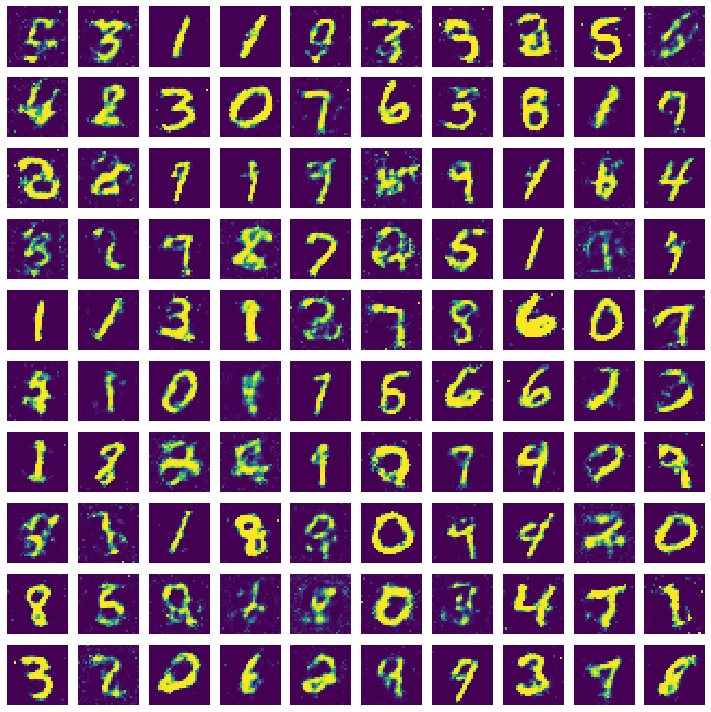

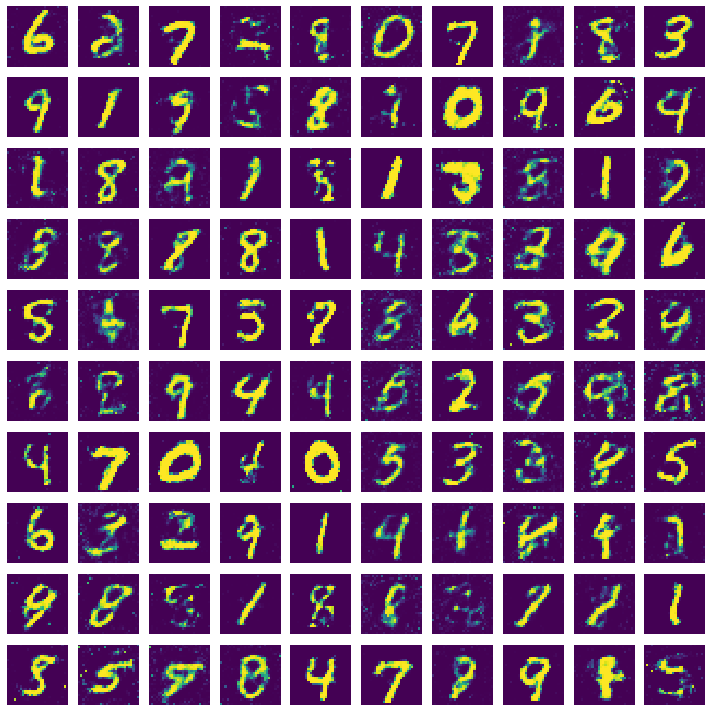

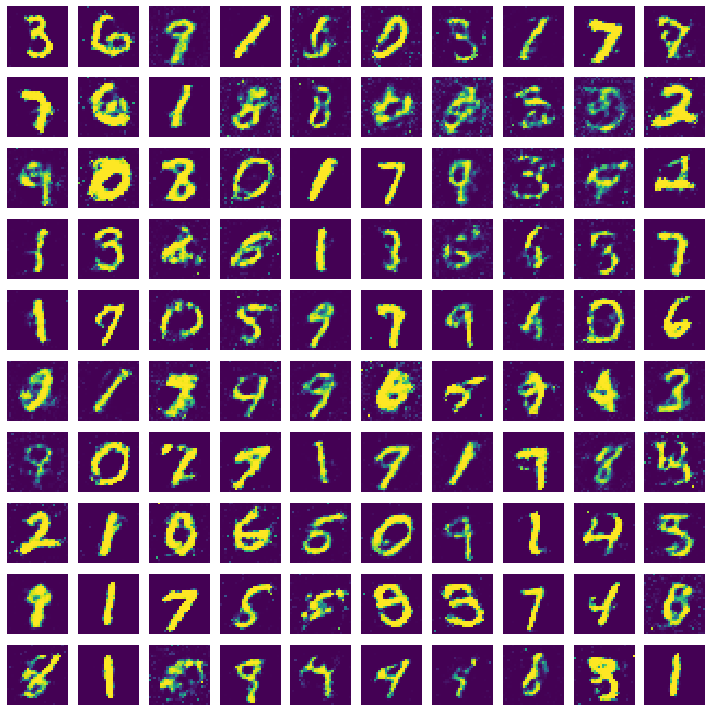

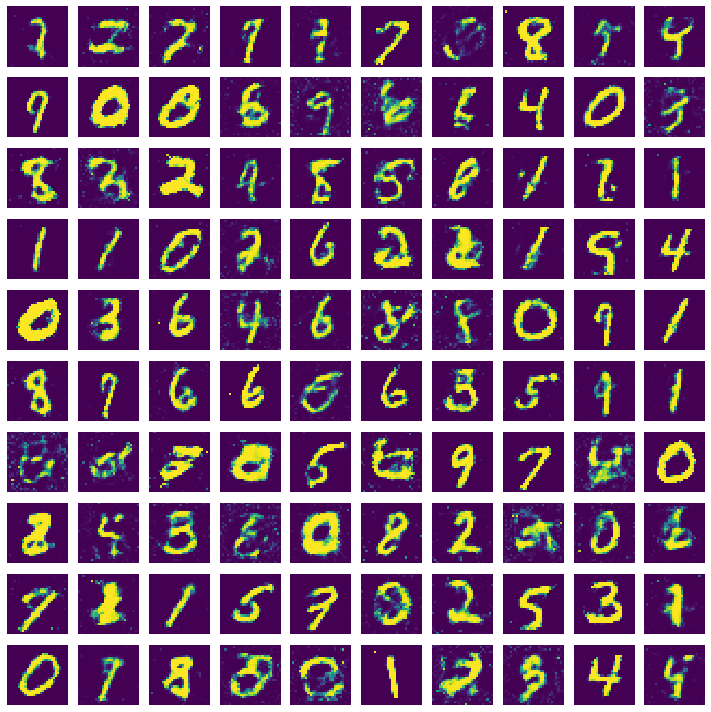

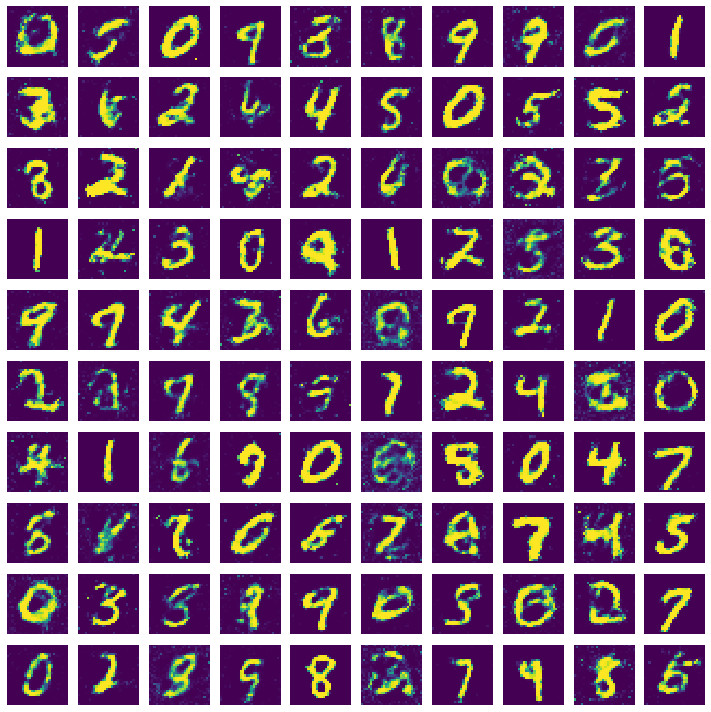

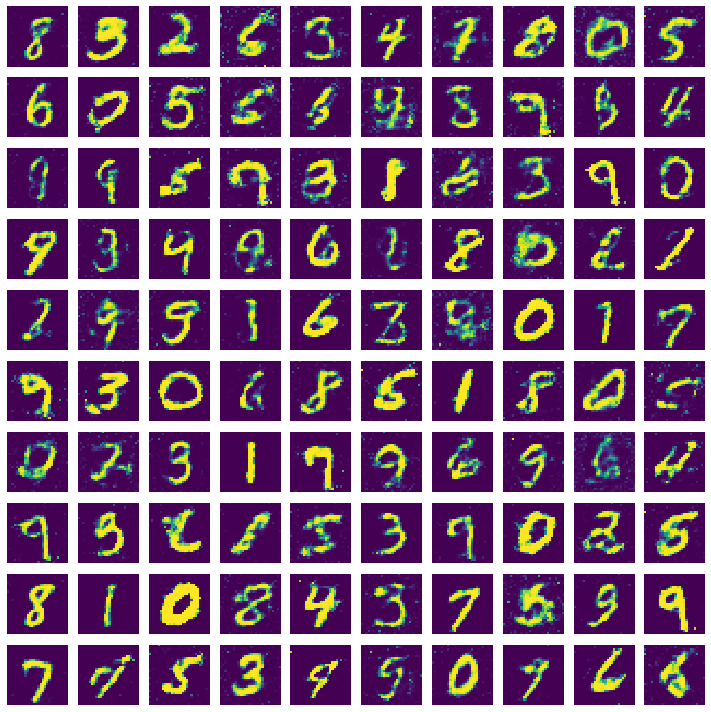

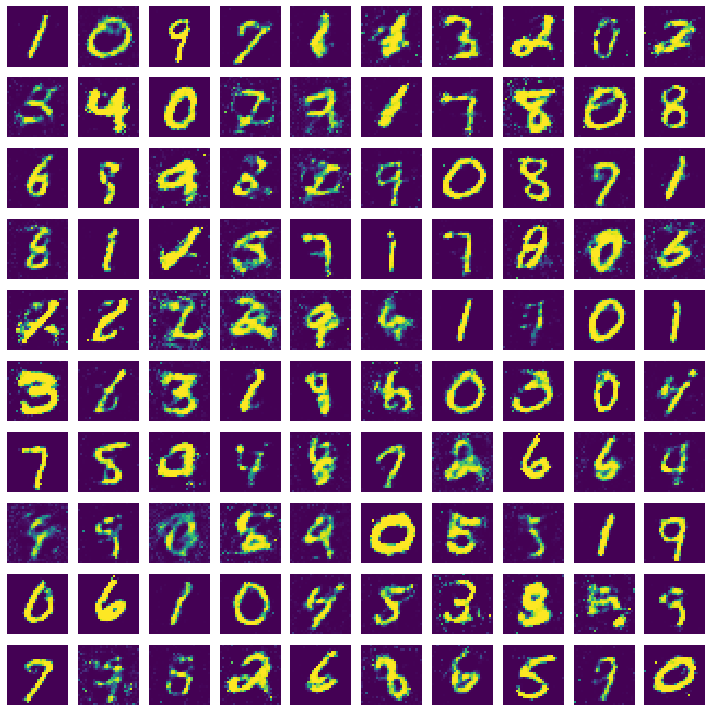

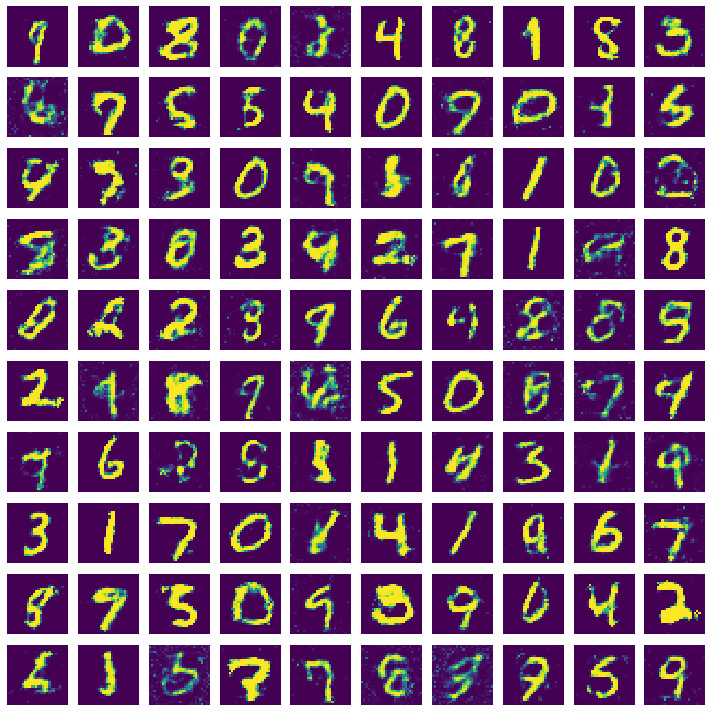

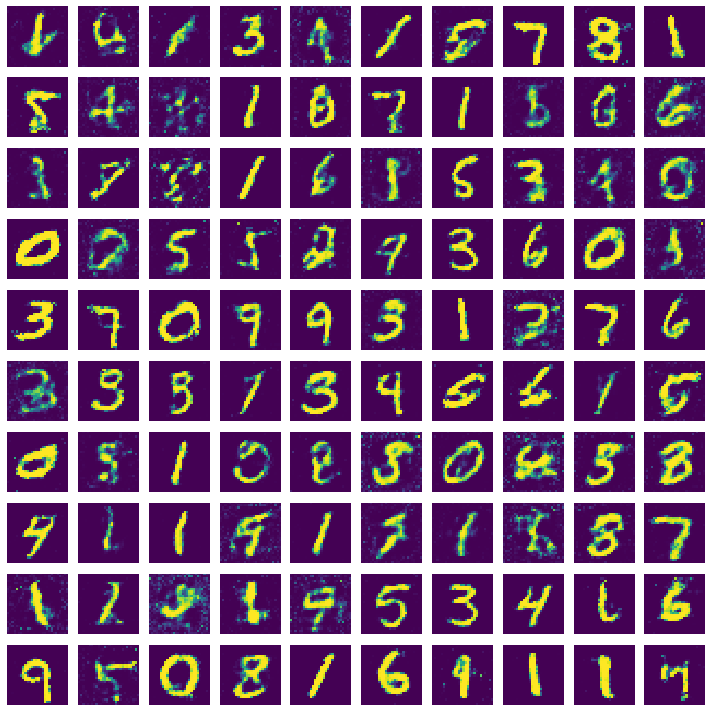

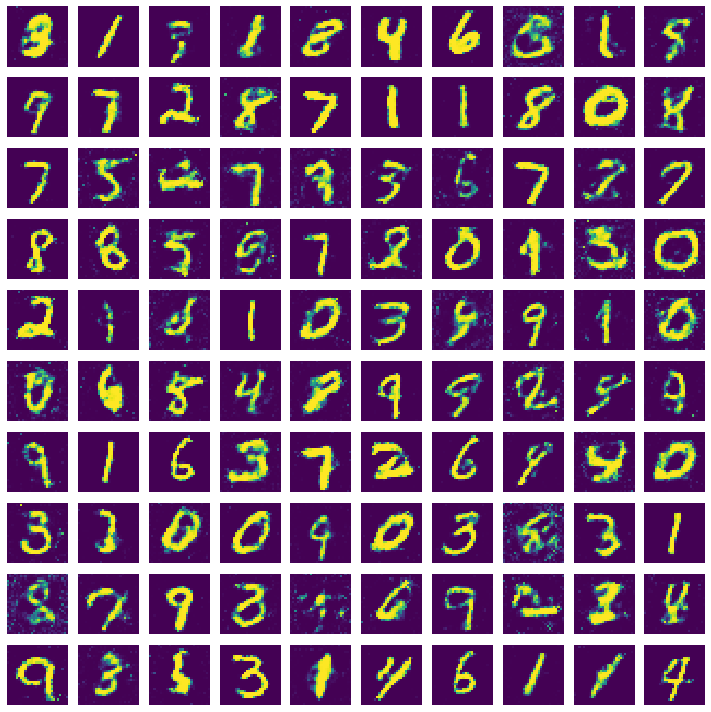

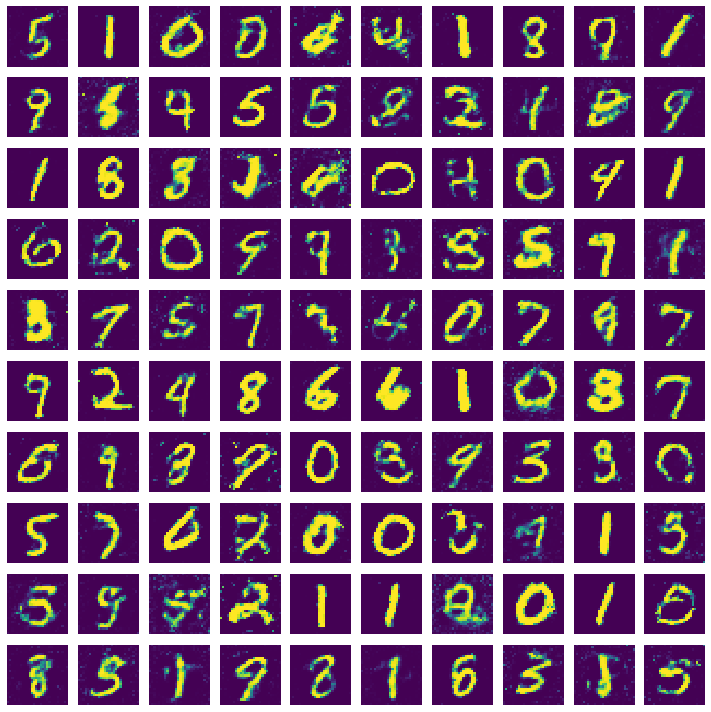

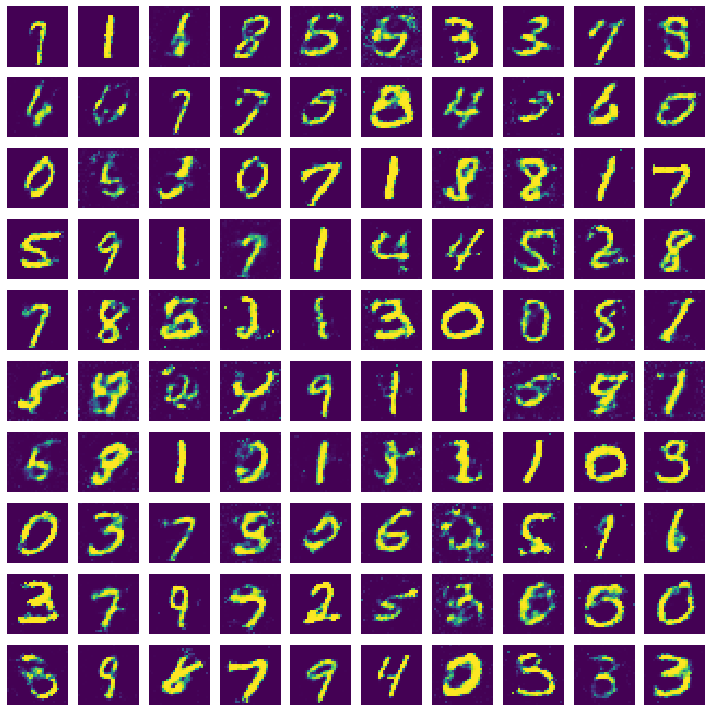

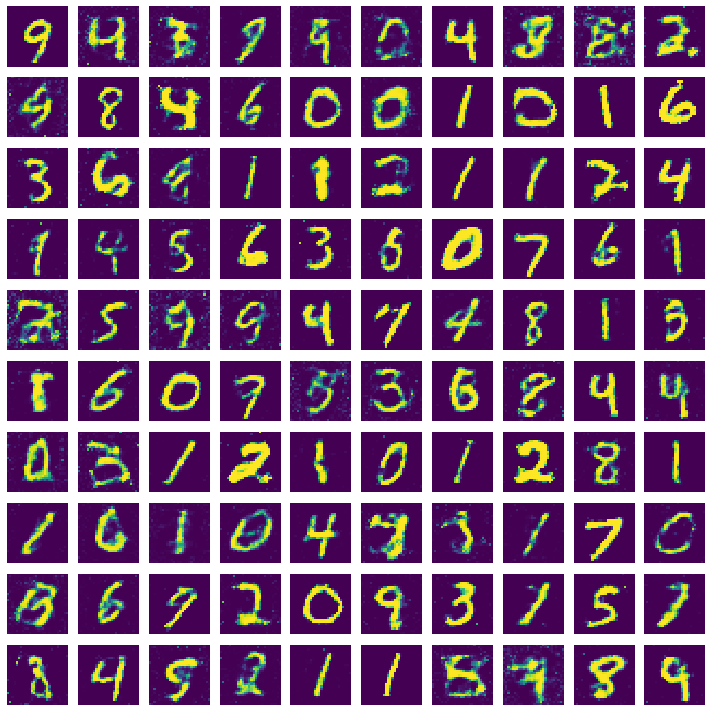

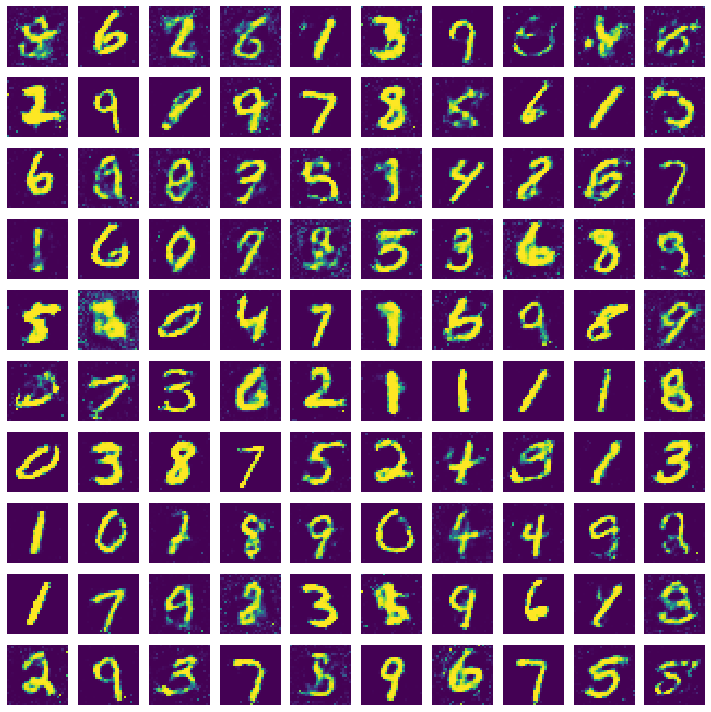

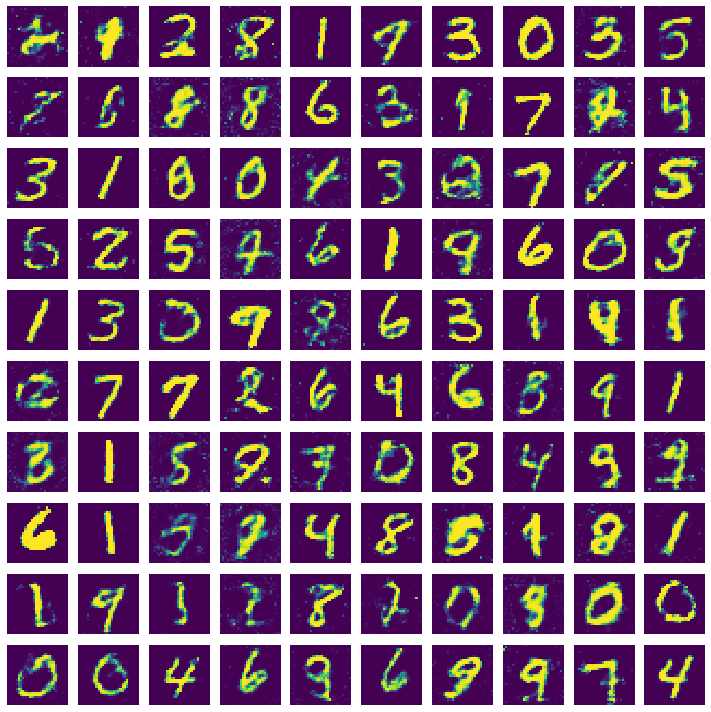

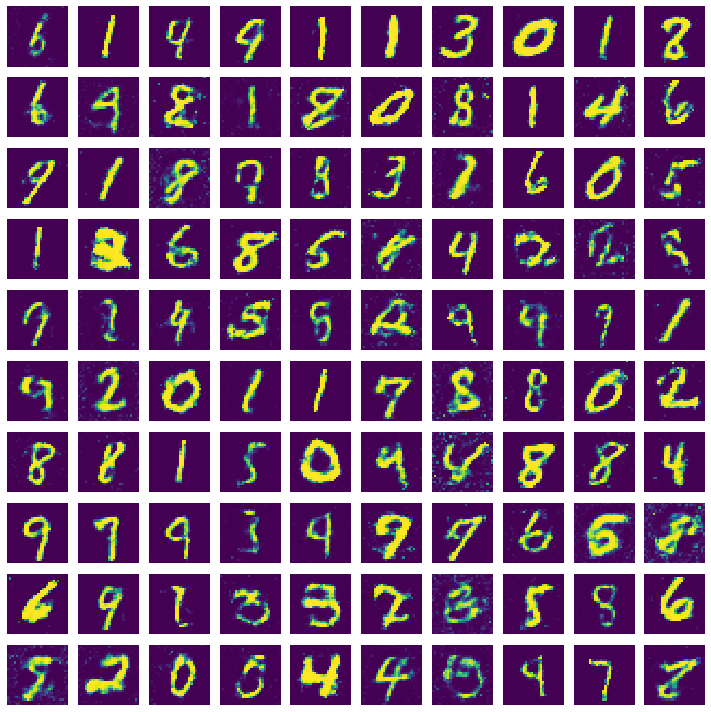

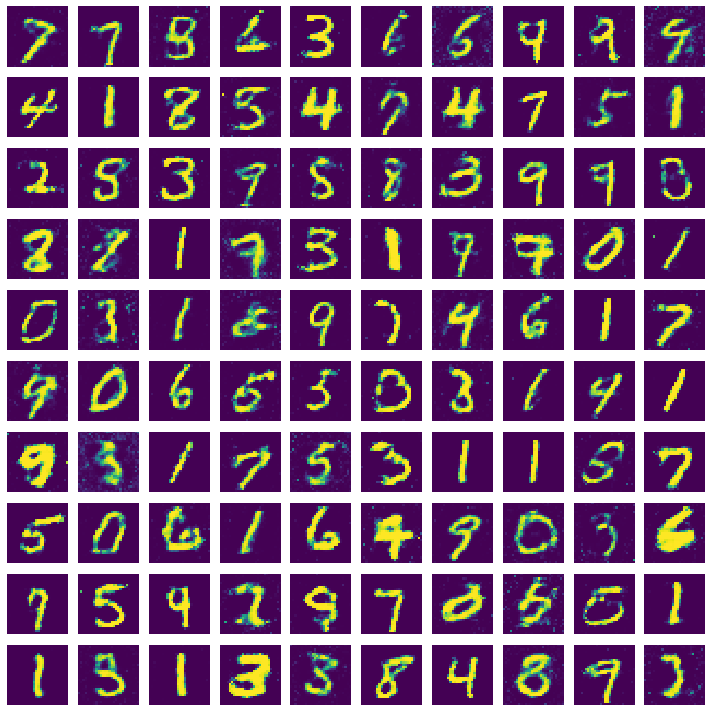

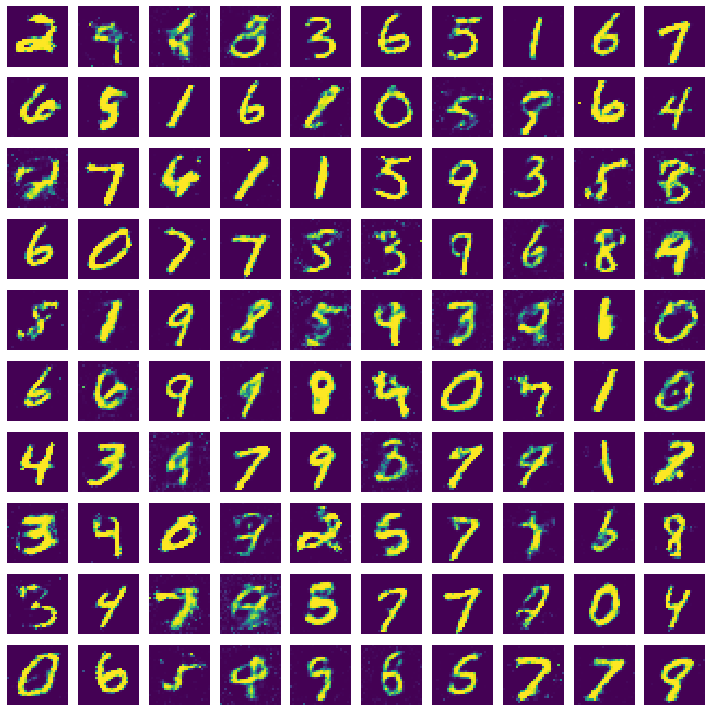

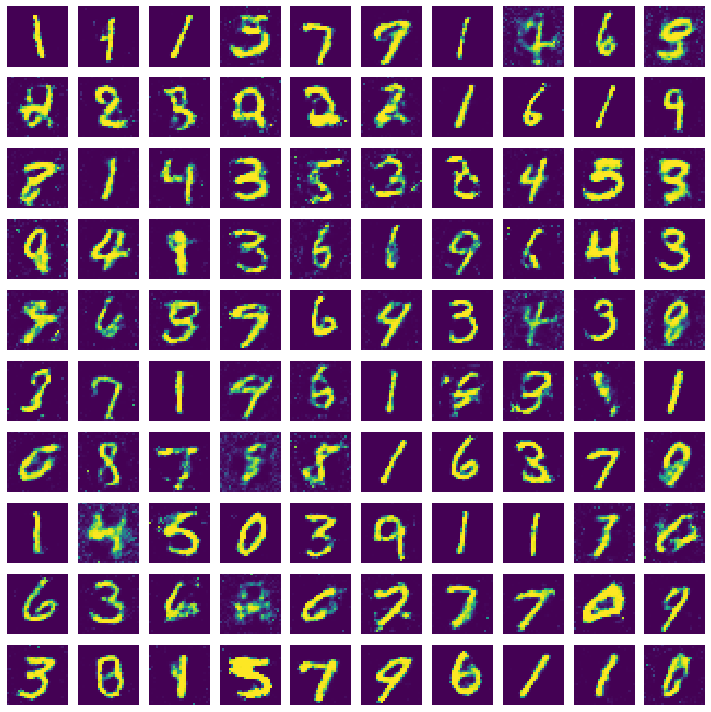

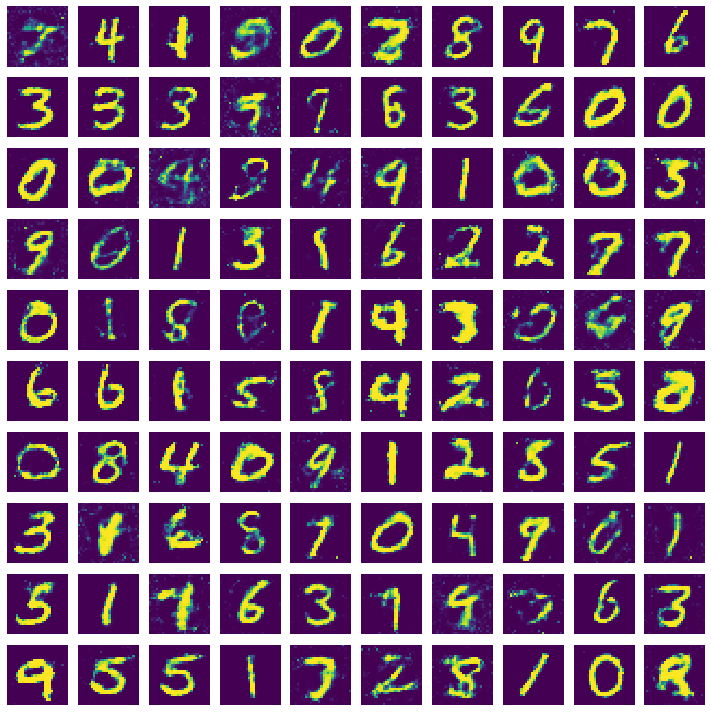

In [5]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (x_train, y_train, x_test, y_test) = load_data()
    batch_count = x_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, (epochs + 1)):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0, 1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0, 1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable = False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 10 == 0:      
            plot_generated_images(e, generator)
training(300,128)